<a href="https://colab.research.google.com/github/PremaKathiresanVasagam/Object_detection_YoloV3/blob/master/Object_Detection_PremaK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Object detection using Yolo V3**

### **Classes**:
- Persons 
- cars

**Preprocess** using https://github.com/ultralytics/JSON2YOLO.git

- **Convert bbox-annotations.json** to coco format **labels** (.txt)
- **Splitting dataset** into Train and Test set **98:2**
- Extract image **resolution** (Width, height) for custom.shapes file. Here,
    - train.shapes
    - test.shapes

Saved as **process.py** in **master branch**

[Github Link](https://github.com/PremaKathiresanVasagam/Object_detection_YoloV3/tree/master)

### Sample images from dataset

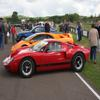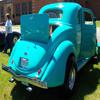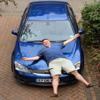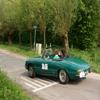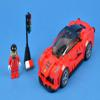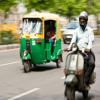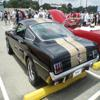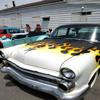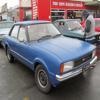

In [ ]:
#process.py
!git clone https://github.com/ultralytics/JSON2YOLO.git

## Clone github repo to load YoloV3 with model config files

**cfg/yolov3-custom.cfg**
<br>
- Classes = **2** (Instead of classes=80) in each yolo layer
- filters = (4+1+**2**)*3 = 21 in each yolo layer

In [1]:
!git clone -b master https://github.com/PremaKathiresanVasagam/Object_detection_YoloV3.git

Cloning into 'Object_detection_YoloV3'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 80 (delta 12), reused 51 (delta 1), pack-reused 0
Unpacking objects: 100% (80/80), done.


In [2]:
cd Object_detection_YoloV3/

/content/Object_detection_YoloV3


### Download the dataset and unzip

Dataset is kept in **/content** folder of colab as it is easier to load

In [54]:
!wget 'https://evp-ml-data.s3.us-east-2.amazonaws.com/ml-interview/openimages-personcar/trainval.tar.gz'

--2021-07-26 04:55:28--  https://evp-ml-data.s3.us-east-2.amazonaws.com/ml-interview/openimages-personcar/trainval.tar.gz
Resolving evp-ml-data.s3.us-east-2.amazonaws.com (evp-ml-data.s3.us-east-2.amazonaws.com)... 52.219.105.170
Connecting to evp-ml-data.s3.us-east-2.amazonaws.com (evp-ml-data.s3.us-east-2.amazonaws.com)|52.219.105.170|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 734266940 (700M) [application/x-gzip]
Saving to: ‘trainval.tar.gz’

trainval.tar.gz     100%[===================>] 700.25M  30.9MB/s    in 24s     

2021-07-26 04:55:52 (29.3 MB/s) - ‘trainval.tar.gz’ saved [734266940/734266940]



In [55]:
print("Unzipping Data...")
!tar -xzf trainval.tar.gz
print("Done!")

Unzipping Data...
Done!


### Move the dataset folder **trainval** under **data/customdata/images** folder

In [ ]:
ls

 cfg/                           __pycache__/      train_batch0.png
 data/                          README.md         train.py
 detect.py                      results.json      trainval/
 models.py                      results.png       trainval.tar.gz
 Object_detection_YoloV3/       results.txt      'ubdivisions=1'
 output/                        test_batch0.png   utils/
 Person_car_detection_yolov3/   test.py           vim.exe.stackdump
 process.py                     ting


In [ ]:
import shutil
shutil.rmtree('trainval/', ignore_errors=True)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


All the **codes and data** - images and labels are present in **Object_detection_YoloV3/**

In [4]:
ls

 cfg/                           process.py        test.py
 data/                          __pycache__/      ting
 detect.py                      README.md         train_batch0.png
 models.py                      results.json      train.py
 Object_detection_YoloV3/       results.png      'ubdivisions=1'
 output/                        results.txt       utils/
 Person_car_detection_yolov3/   test_batch0.png   vim.exe.stackdump


In [56]:
cd ..

/content


Move **labels** from gdrive to **/drive** folder of colab from there move it to **Object_detection_YoloV3 -> data -> customdata -> labels** 

In [57]:
## This uses -qq to make the unzipping less verbose.
!unzip -qq 'drive/MyDrive/EV_Yolo_Data/labels.zip' -d 'Object_detection_YoloV3/data/customdata/'
print("Unzipping done!")

Unzipping done!


Create a new folder **weights** and save the default **pretrained yolo weights**
<br> **yolov3-spp-ultralytics.pt**

In [29]:
import time
import glob
import torch
import os
from torchsummary import summary

import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image, clear_output 
print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 1.9.0+cu102 CPU


In [ ]:
ls

drive/  Object_detection_YoloV3/  sample_data/


In [ ]:
cd Object_detection_YoloV3/

/content/Object_detection_YoloV3


In [ ]:
ls

 cfg/        process.py     results.txt        train.py            weights/
 data/       __pycache__/   test_batch0.png    trainval.tar.gz
 detect.py   README.md      test.py           'ubdivisions=1'
 models.py   results.json   ting               utils/
 output/     results.png    train_batch0.png   vim.exe.stackdump


**Hyper parameters:**
- max_batches = 4000 (#classes * 2000)
- steps = 3200, 3600 (0.8 * max_batches , 0.9 * max_batches)
- batch_size = 64 (Minimise the value if we run into cuda out of memory error)
- sub divisions = 16. 
Lower the number of subdivisions (change the subdivision size to speed up training (smaller subdivisions are faster) or if your GPU does not have enough memory (larger subdivisions require less memory)
- Input Resolution = 608x608 (Any value multiple of 32 - 416, 832)

**Metrics:**
<br> GIoU, objectness, classification, precision, recall, mAP@0.5, F1 Score

In [62]:
cd /content/Object_detection_YoloV3/

/content/Object_detection_YoloV3


**Train Test Split:** #images
<br> Train: 2015
<br> Validation: 224

In [ ]:
!python train.py --data data/customdata/custom.data --batch 10 --cache --cfg cfg/yolov3-custom.cfg --epochs 25

Namespace(accumulate=4, adam=False, batch_size=10, bucket='', cache_images=True, cfg='cfg/yolov3-custom.cfg', data='data/customdata/custom.data', device='', epochs=2, evolve=False, img_size=[512], multi_scale=False, name='', nosave=False, notest=False, rect=False, resume=False, single_cls=False, weights='weights/yolov3-spp-ultralytics.pt')
Using CPU

2021-07-26 05:07:52.978837: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Run 'tensorboard --logdir=runs' to view tensorboard at http://localhost:6006/
Model Summary: 225 layers, 6.25787e+07 parameters, 6.25787e+07 gradients
Caching labels (2015 found, 0 missing, 0 empty, 0 duplicate, for 2015 images): 100% 2015/2015 [00:00<00:00, 6425.58it/s]
Caching images (1.1GB): 100% 2015/2015 [00:25<00:00, 77.70it/s]
Reading image shapes: 100% 224/224 [00:00<00:00, 5652.29it/s]
Caching labels (224 found, 0 missing, 0 empty, 0 duplicate, for 224 images): 100% 224/224 [00:00<00:00,

We need to train longer, as I had time constraint and GPU resources constraint, couldn't train longer. 
<br> Maximum: Trained upto 44 epochs.

In [59]:
cd ..

/


In [24]:
ls

best.pt  images.zip  labels.zip  last.pt


In [23]:
cd MyDrive/EV_Yolo_Data/

/content/drive/MyDrive/EV_Yolo_Data


In [27]:
model = torch.load('best.pt', map_location=torch.device('cpu'))

In [40]:
cd Object_detection_YoloV3/

/content/Object_detection_YoloV3


## Testing data:

In [53]:
!python detect.py --conf-thres 0.1 --output out_out --weights weights/best.pt

Namespace(agnostic_nms=False, augment=False, cfg='cfg/yolov3-custom.cfg', classes=None, conf_thres=0.1, device='', fourcc='mp4v', half=False, img_size=512, iou_thres=0.6, names='data/customdata/custom.names', output='out_out', save_txt=False, source='data/customdata/images', view_img=False, weights='weights/best.pt')
Using CPU

Model Summary: 225 layers, 6.25787e+07 parameters, 6.25787e+07 gradients
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
image 1/3 data/customdata/images/test_img_1.jpg: 320x512 1 cars, Done. (1.117s)
image 2/3 data/customdata/images/test_img_2.jpeg: 320x512 6 persons, 2 cars, Done. (1.105s)
image 3/3 data/custom

Test Image 1:

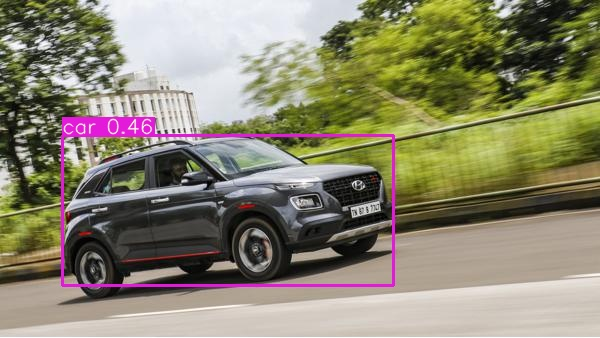

Test Image 2:

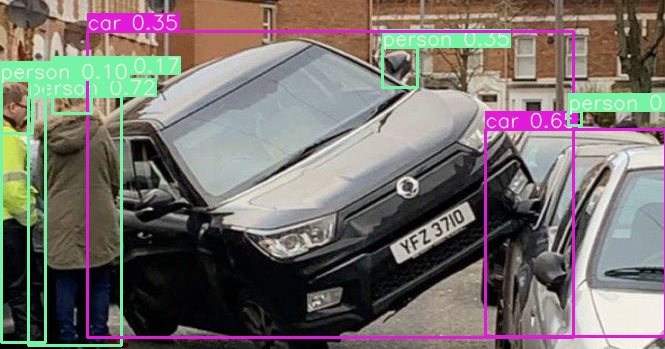

Test Image 3:

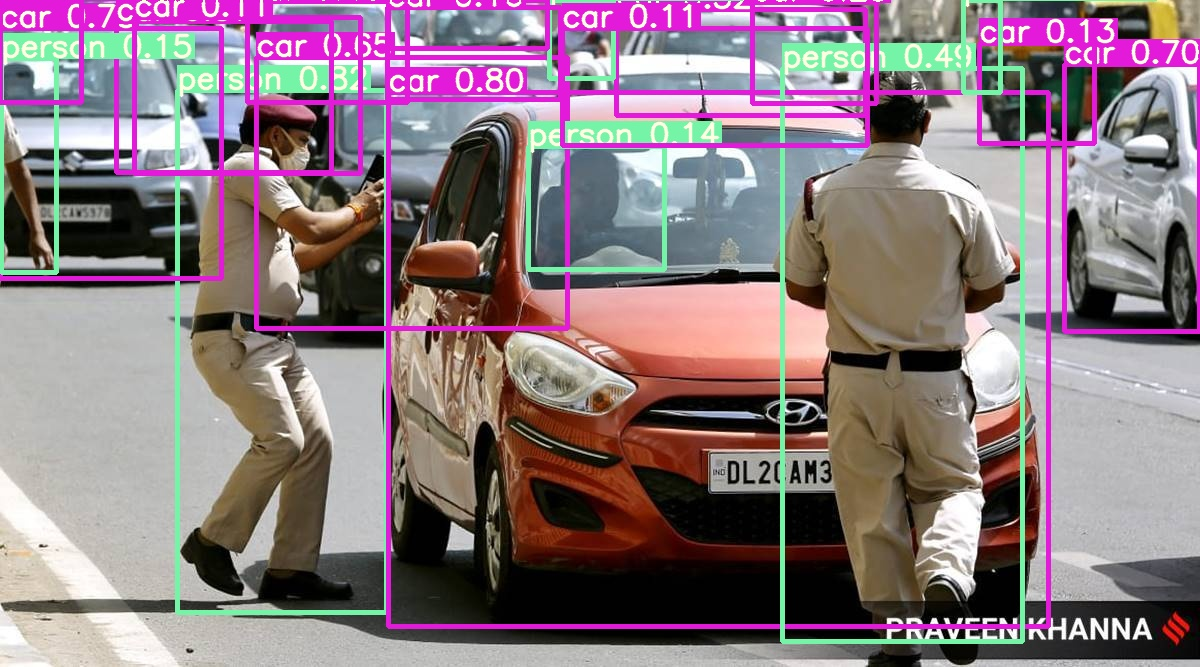

**Next steps:**
- Data Augmentations like Horizontal & vertical flip, rotation,Mosaic
- Longer training: Run for 300 epochs for better results